In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv


<a id="table-of-content"></a>
# Table of Content
### [1. Import Libraries](#import-libraries)
### [2. Loading Data](#loading-data)
### [3. Data Exploration](#data-exploration)
- [Correlation Matrix](#correlation-matrix)
- [Data Distribution](#data-distribution)
- [Divide box plot into "No Failure" & "Failure"](#divide-box-plot)
- [Rename Columns](#rename-columns)
- [Removes useless & correlated features](#removes-features)
- [Pair Plot](#pair-plot)

### [4. Imbalanced Data](#imbalanced-data)
### [5. One Hot Encoding](#encoding)
- [get_dummies approach](#get-dummies)

### [6. Train-Test Split](#train-test-split)
### [7. Classify Imbalanced Data](#classify-imbalanced-data)
### [8. Resampling Data + Modelling](#resampling-data)
- [Random Forest Classifier](#random-forest)
- [Gradient Boosting Classifier](#GBT)
- [XGBoost](#xgboost)

### [9. Conclusion](#conclusion)
### [Go to end](#end)

<a id="import-libraries"></a>
# Import Libraries

In [2]:
import pandas as pd
import imblearn
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE 

<a id="loading-data"></a>
# Loading Data

In [3]:
df = pd.read_csv('../input/machine-predictive-maintenance-classification/predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


<a id="data-exploration"></a>
# Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
dtype: int64

**Findings:**
1. There is no missing value in the data
2. UDI and ProductID are unique for each instances


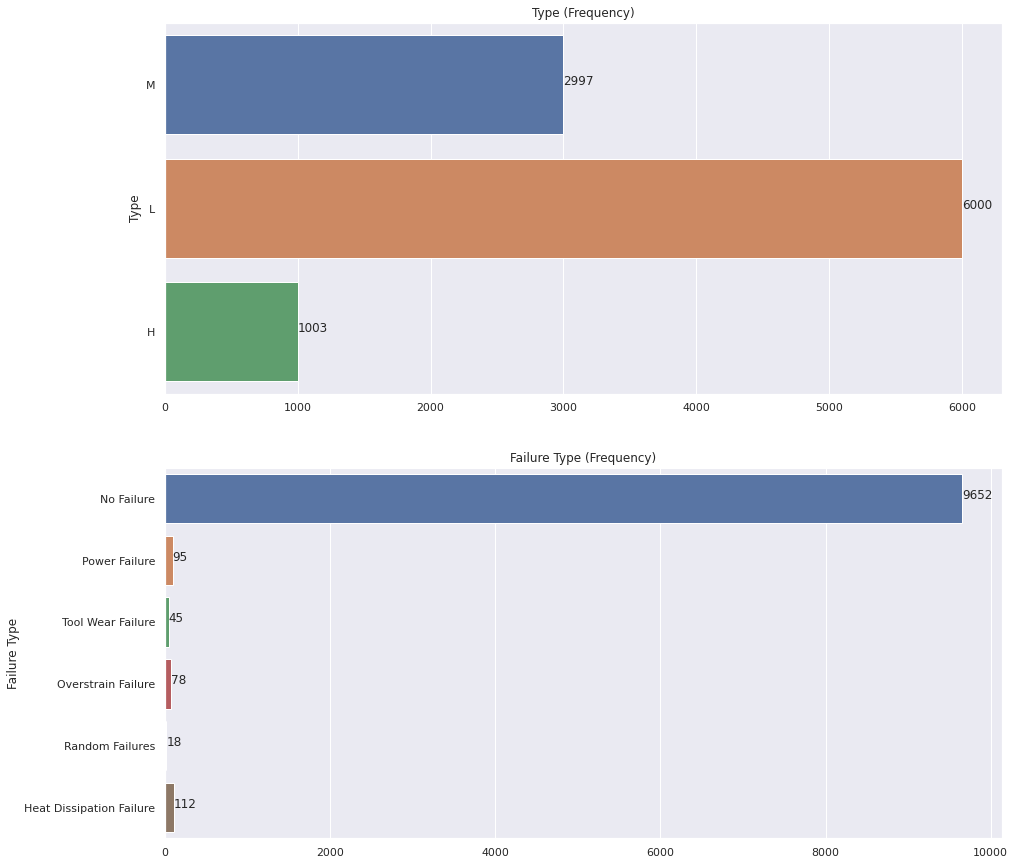

In [6]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
pl = sns.countplot(y=df["Type"])
pl.set_title("Type (Frequency)")
pl.set(xlabel=None)
for p in pl.patches:
        percentage = p.get_width()
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        pl.annotate(percentage, (x, y))
plt.subplot(2,1,2)
pl2 = sns.countplot(y=df["Failure Type"])
pl2.set_title("Failure Type (Frequency)")
pl2.set(xlabel=None)
for p in pl2.patches:
        percentage = p.get_width()
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        pl2.annotate(percentage, (x, y))
plt.show()

<a id="correlation-matrix"></a>
## Correlation Matrix

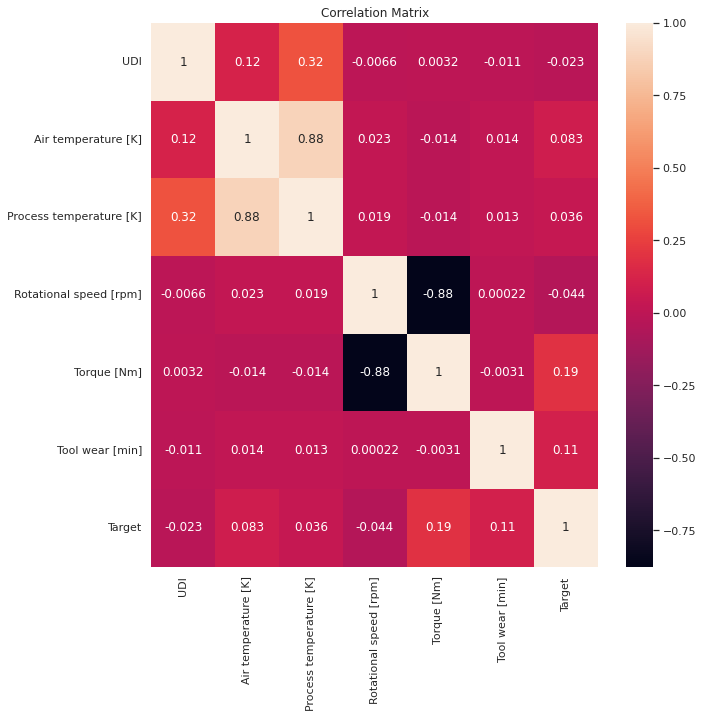

In [7]:
plt.figure(figsize=(10,10))
pl = sns.heatmap(df.corr(), annot=True)
pl.set_title("Correlation Matrix")
plt.show()

We need to remove:
1. ("Torque \[Nm\]" or "Rotational speed \[rpm\]")
2. ("Air temperature \[K\]" or "Process temperature \[K\]")
<br></br>
to make this decision, I decided to view compare their data distribution against failure type.

In [8]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


There might be outliers in "Rotational speed \[rpm]", "Torque [Nm]", and "Tool wear [min]"

<a id="data-distribution"></a>
## Data Distribution

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


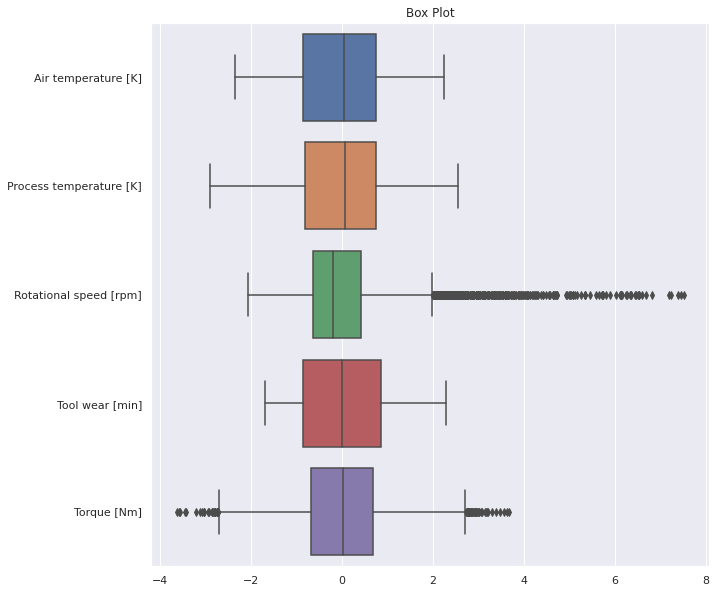

In [9]:
plt.figure(figsize=(10,10))
df_drop = df.drop(columns=['Target','Product ID', 'UDI','Type'])
df_normalize=(df_drop-df_drop.mean())/df_drop.std()
pl=sns.boxplot(data=df_normalize.drop(columns='Failure Type'), orient = 'h')
pl.set_title("Box Plot")
plt.show()

Chances are these outliers could be the cause of failure

<a id="divide-box-plot"></a>
## Divide box plot into "No Failure" & "Failure" 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app


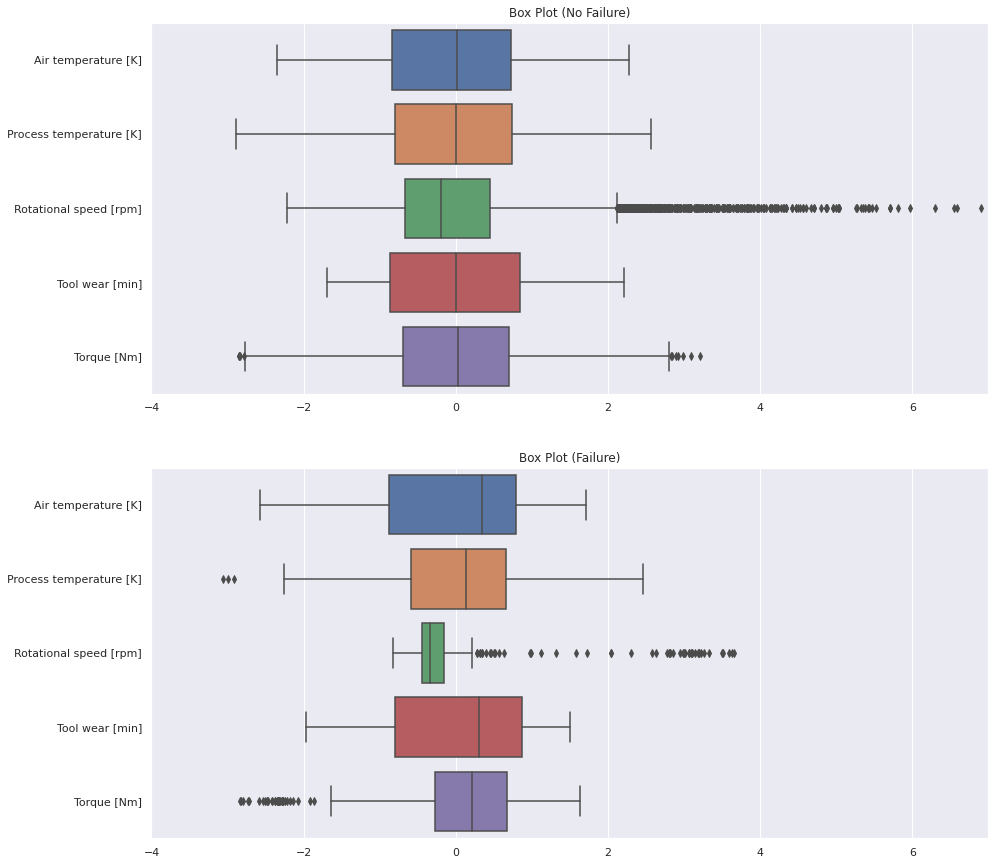

In [10]:
plt.figure(figsize=(15,15))
df_drop = df.drop(columns=['Target','Product ID', 'UDI','Type'])

plt.subplot(2,1,1)
df_no_fail = df_drop[df_drop['Failure Type']=="No Failure"]
# pl = sns.boxplot(data=df_no_fail)
df_normalize=(df_no_fail-df_no_fail.mean())/df_no_fail.std()
pl=sns.boxplot(data=df_normalize.drop(columns='Failure Type'), orient = 'h')
pl.set_xlim([-4, 7])
pl.set_title("Box Plot (No Failure)")

plt.subplot(2,1,2)
df_fail = df_drop[df_drop['Failure Type']!="No Failure"]
# pl = sns.boxplot(data=df_no_fail)
df_normalize=(df_fail-df_fail.mean())/df_fail.std()
pl=sns.boxplot(data=df_normalize.drop(columns='Failure Type'), orient = 'h')
pl.set_xlim([-4, 7])
pl.set_title("Box Plot (Failure)")
plt.show()

1. Data distribution of "Air temperature \[K\]" is different for "Failure" and "No Failure" (at least more obvious than "Process temperature \[K\]") so I decided to remove "Process temperature \[K\]".
2. Rotational speed \[rpm\] hsa obvious difference between "Failure" and "No Failure" so I decided to remove "Torque \[Nm\]".

<a id="rename-columns"></a>
## Rename Columns

In [11]:
df['Air temperature'] = df['Air temperature [K]']
df['Rotational speed'] = df['Rotational speed [rpm]']
df['Tool wear'] = df['Tool wear [min]']
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature,Rotational speed,Tool wear
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,298.1,1551,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,298.2,1408,3
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure,298.1,1498,5
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure,298.2,1433,7
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure,298.2,1408,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure,298.8,1604,14
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure,298.9,1632,17
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure,299.0,1645,22
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure,299.0,1408,25


<a id="removes-features"></a>
## Removes useless and correlated features

In [12]:
df.drop(columns = ['UDI','Product ID', 'Process temperature [K]', 'Torque [Nm]', 'Target','Air temperature [K]','Rotational speed [rpm]','Tool wear [min]'], inplace = True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              10000 non-null  object 
 1   Failure Type      10000 non-null  object 
 2   Air temperature   10000 non-null  float64
 3   Rotational speed  10000 non-null  int64  
 4   Tool wear         10000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 390.8+ KB


In [14]:
df.columns

Index(['Type', 'Failure Type', 'Air temperature', 'Rotational speed',
       'Tool wear'],
      dtype='object')

<a id="pair-plot"></a>
## Pairplot

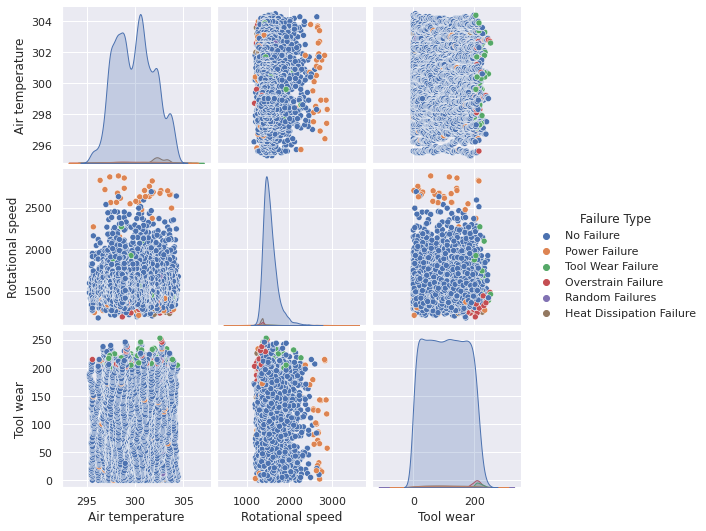

In [15]:
sns.pairplot(df, hue = "Failure Type")
plt.show()

<a id="imbalanced-data"></a>
# Imbalanced Data

Data distribution of the failures are not obvious due to imbalanced data.

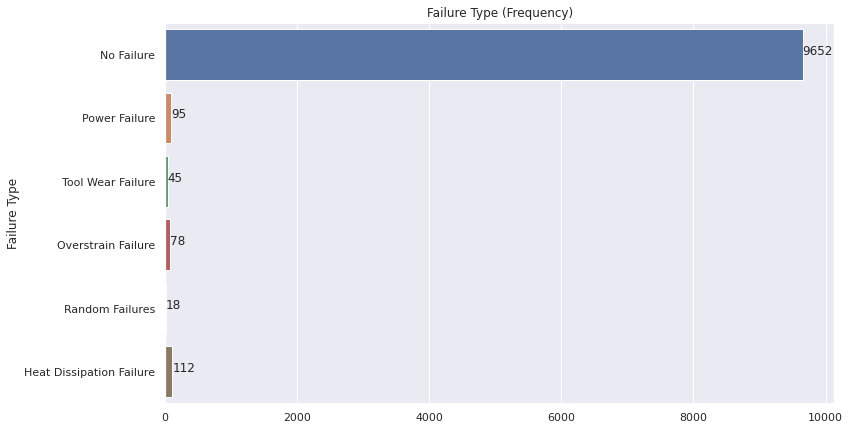

In [16]:
plt.figure(figsize=(12,7))
pl = sns.countplot(y=df["Failure Type"])
pl.set_title("Failure Type (Frequency)")
pl.set(xlabel=None)
for p in pl.patches:
        percentage = p.get_width()
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        pl.annotate(percentage, (x, y))
plt.show()

<a id="encoding"></a>
# One Hot Encoding

In [17]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
transformed = encoder.fit_transform(df['Type'].to_numpy().reshape(-1,1)).toarray()
enc_df = pd.DataFrame(transformed)
df2 = df.join(enc_df)
df2

,Type,Failure Type,Air temperature,Rotational speed,Tool wear,0,1,2
0,M,No Failure,298.1,1551,0,0.0,0.0,1.0
1,L,No Failure,298.2,1408,3,0.0,1.0,0.0
2,L,No Failure,298.1,1498,5,0.0,1.0,0.0
3,L,No Failure,298.2,1433,7,0.0,1.0,0.0
4,L,No Failure,298.2,1408,9,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
9995,M,No Failure,298.8,1604,14,0.0,0.0,1.0
9996,H,No Failure,298.9,1632,17,1.0,0.0,0.0
9997,M,No Failure,299.0,1645,22,0.0,0.0,1.0
9998,H,No Failure,299.0,1408,25,1.0,0.0,0.0


<a id="get-dummies"></a>
## get_dummies approach

In [18]:
dum_df = pd.get_dummies(df,columns = ['Type'], prefix = ['Type'])
dum_df

,Failure Type,Air temperature,Rotational speed,Tool wear,Type_H,Type_L,Type_M
0,No Failure,298.1,1551,0,0,0,1
1,No Failure,298.2,1408,3,0,1,0
2,No Failure,298.1,1498,5,0,1,0
3,No Failure,298.2,1433,7,0,1,0
4,No Failure,298.2,1408,9,0,1,0
...,...,...,...,...,...,...,...
9995,No Failure,298.8,1604,14,0,0,1
9996,No Failure,298.9,1632,17,1,0,0
9997,No Failure,299.0,1645,22,0,0,1
9998,No Failure,299.0,1408,25,1,0,0


Let's use dum_df since it saved our time of renaming the columns

In [19]:
# Removes "Type_H" to reduce multicollinearity
df = dum_df.drop(columns = ['Type_H'])
df

,Failure Type,Air temperature,Rotational speed,Tool wear,Type_L,Type_M
0,No Failure,298.1,1551,0,0,1
1,No Failure,298.2,1408,3,1,0
2,No Failure,298.1,1498,5,1,0
3,No Failure,298.2,1433,7,1,0
4,No Failure,298.2,1408,9,1,0
...,...,...,...,...,...,...
9995,No Failure,298.8,1604,14,0,1
9996,No Failure,298.9,1632,17,0,0
9997,No Failure,299.0,1645,22,0,1
9998,No Failure,299.0,1408,25,0,0


<a id="train-test-split"></a>
# Train-Test Split

We need to split our data set before over sampling to prevent information leak into validation and testing set. This will over fit the testing set.

In [20]:
# Define X and y
X = df.drop(columns = 'Failure Type')
y = df["Failure Type"]

In [21]:
X

,Air temperature,Rotational speed,Tool wear,Type_L,Type_M
0,298.1,1551,0,0,1
1,298.2,1408,3,1,0
2,298.1,1498,5,1,0
3,298.2,1433,7,1,0
4,298.2,1408,9,1,0
...,...,...,...,...,...
9995,298.8,1604,14,0,1
9996,298.9,1632,17,0,0
9997,299.0,1645,22,0,1
9998,299.0,1408,25,0,0


In [22]:
y

0       No Failure
1       No Failure
2       No Failure
3       No Failure
4       No Failure
           ...    
9995    No Failure
9996    No Failure
9997    No Failure
9998    No Failure
9999    No Failure
Name: Failure Type, Length: 10000, dtype: object

In [23]:
# Number of instances for each class
from collections import Counter
print(sorted(Counter(y).items()))

[('Heat Dissipation Failure', 112), ('No Failure', 9652), ('Overstrain Failure', 78), ('Power Failure', 95), ('Random Failures', 18), ('Tool Wear Failure', 45)]


In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [25]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
# train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1)
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 5) (2000, 5) (8000,) (2000,)


In [27]:
# Number of instances for each class
from collections import Counter
print(sorted(Counter(y).items()))

[(0, 112), (1, 9652), (2, 78), (3, 95), (4, 18), (5, 45)]


<a id="classify-imbalanced-data"></a>
# Classifying Imbalanced Data

In [28]:
# Classifying imbalanced data
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X,y)

cv_results = cross_validate(
    model, X, y, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True,
    n_jobs=-1
)
cv_results

{'fit_time': array([1.15897655, 1.16409349, 1.26991272, 1.18251538, 0.85187531]),
 'score_time': array([0.05104828, 0.05272746, 0.05120277, 0.05474687, 0.03821588]),
 'estimator': (RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier()),
 'test_score': array([0.29595398, 0.31135161, 0.21320128, 0.2464456 , 0.31055751]),
 'train_score': array([1.        , 1.        , 1.        , 0.99780702, 1.        ])}

We get very low accuracy (30%) due to imbalanced data.

In [29]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(model, X_train, y_train, cv=3)

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,y_train_predict)
cm

array([[  26,   61,    3,    0,    0,    0],
       [  35, 7661,   14,   11,    0,    1],
       [   2,   40,   20,    0,    0,    0],
       [   3,   56,    0,   17,    0,    0],
       [   1,   13,    0,    0,    0,    0],
       [   0,   36,    0,    0,    0,    0]])

Visualize the matrix to better evaluate the model 

### Define y_class

In [31]:
from sklearn.metrics import classification_report
cr = classification_report(y_train,y_train_predict, output_dict=True)

y_list = []

for key, values in cr.items():
    y_list.append(key)

y_class_str = []
    
for i in y_list[:6]:
    y_class_str.append(int(i))
    
y_class_str

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0, 1, 2, 3, 4, 5]

In [32]:
y_class = le.inverse_transform(y_class_str)
y_class

array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure'],
      dtype=object)

This list is going to be our x & y axes for our confusion matrix heat map

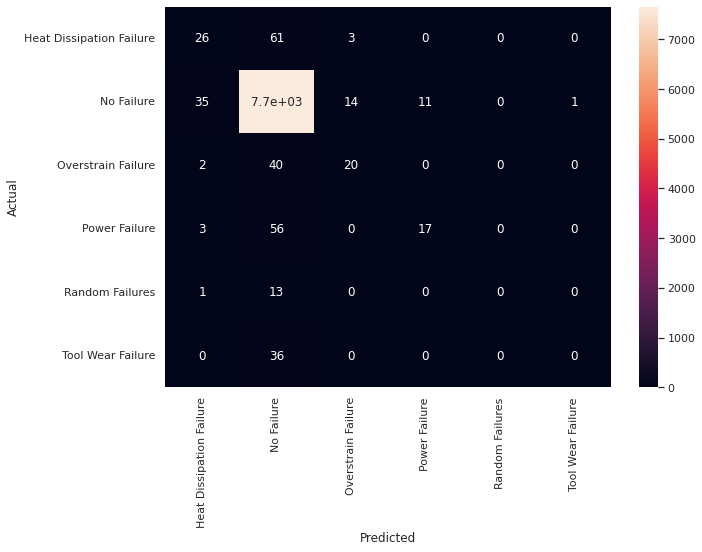

In [33]:
df_cm = pd.DataFrame(cm, index = [y_class],
                  columns = y_class)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From the heat map, we can say that:
1. The model is heavily biased towards majority class
2. Minority classes are heavily underfitted

What about the precision-recall and f1 score?

In [34]:
print(classification_report(y_train,y_train_predict))

              precision    recall  f1-score   support

           0       0.39      0.29      0.33        90
           1       0.97      0.99      0.98      7722
           2       0.54      0.32      0.40        62
           3       0.61      0.22      0.33        76
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        36

    accuracy                           0.97      8000
   macro avg       0.42      0.30      0.34      8000
weighted avg       0.95      0.97      0.96      8000



Consistent with our heat map, minority classes are heavily underfitted especially "Random Failure" & "Tool Wear Failure" (Recall = 0). Out of 50 failures the model catch none of them which is very bad. When the data is highly imbalanced, the model wasn't exposed to the minority class enough and was taught to predict the mojority class most of the time. Therefore, we shoud resample our data such that the majority class and minority classes have equal chance to be seen by the model. 

<a id="resampling-data"></a>
# Resampling Data + Modelling

Note that we're resampling our data after train-test split so that information from the training set didn't leak into the testing set.

Credit to this [article](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html) for the right way to oversample without polluting your validation set.

In [35]:
# from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
# kf = KFold(n_splits=5, random_state=42, shuffle=False)
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [36]:
from imblearn.under_sampling import RandomUnderSampler

<a id="random-forest"></a>
## Random Forest Classifier

In [37]:
# parameters for grid search
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}
# Add classifier's name for grid search
pipe_rf_params = {'randomforestclassifier__' + key: rf_params[key] for key in rf_params}
pipe_rf_params

{'randomforestclassifier__n_estimators': [50, 100, 150],
 'randomforestclassifier__max_depth': [4, 6, 10, 12],
 'randomforestclassifier__random_state': [13]}

In [38]:
# from imblearn.pipeline import Pipeline, make_pipeline
# from imblearn.over_sampling import SMOTE 
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV


rf_pipeline = make_pipeline(RandomUnderSampler(sampling_strategy='majority'),SMOTE(random_state=42), 
                              RandomForestClassifier(random_state=13))

# use recall_weighted instead of recall because this is multiclass
grid_rf = GridSearchCV(rf_pipeline, param_grid=pipe_rf_params, cv=skf,scoring='recall_weighted',
                        return_train_score=True)
grid_rf.fit(X_train, y_train)
grid_rf.best_score_

0.45562500000000006

In [39]:
grid_rf.best_params_

{'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__n_estimators': 150,
 'randomforestclassifier__random_state': 13}

It is important for us to test on testing set instead of validation set because we're using grid search which could overfit the validation set.

In [40]:
y_train_predict = grid_rf.predict(X_train)
cm_val = confusion_matrix(y_train,y_train_predict)

y_test_predict = grid_rf.predict(X_test)
cm_test = confusion_matrix(y_test,y_test_predict)

print("Validation Score:")
print(cm_val)
print("Test Score:")
print(cm_test)

Validation Score:
[[  84    0    4    2    0    0]
 [ 188 2104  100 1426 3251  653]
 [   3    0   51    1    1    6]
 [  12   10    3   47    2    2]
 [   2    1    0    0   10    1]
 [   0    0    3    0    0   33]]
Test Score:
[[ 20   0   2   0   0   0]
 [ 43 490  28 381 838 150]
 [  1   1  12   1   0   1]
 [  1   1   0  15   2   0]
 [  1   2   0   0   1   0]
 [  0   0   1   0   0   8]]


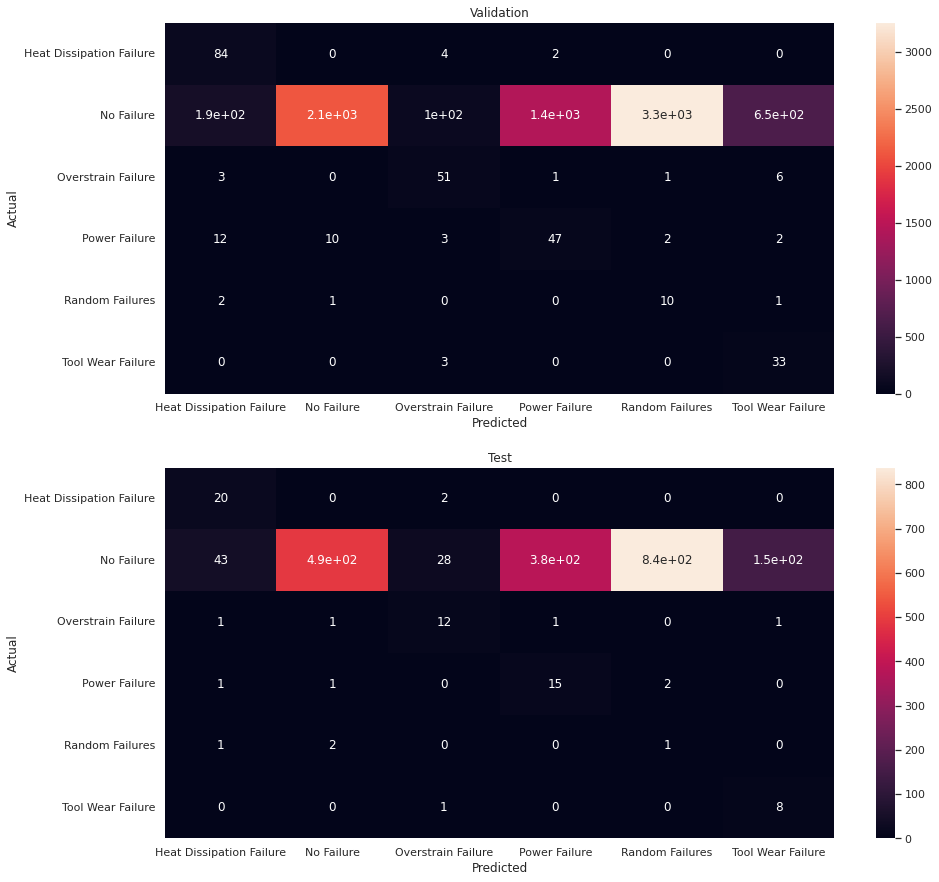

In [41]:
df_val = pd.DataFrame(cm_val, index = [y_class],
                  columns = y_class)

df_test = pd.DataFrame(cm_test, index = [y_class],
                  columns = y_class)

plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
pl = sns.heatmap(df_val, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
pl.set_title("Validation")

plt.subplot(2,1,2)
pl2 = sns.heatmap(df_test, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
pl2.set_title("Test")
plt.show()

In [42]:
print("Validation Score:")
print(classification_report(y_train,y_train_predict))
print("")
print("Test Score:")
print(classification_report(y_test,y_test_predict))

Validation Score:
              precision    recall  f1-score   support

           0       0.29      0.93      0.44        90
           1       0.99      0.27      0.43      7722
           2       0.32      0.82      0.46        62
           3       0.03      0.62      0.06        76
           4       0.00      0.71      0.01        14
           5       0.05      0.92      0.09        36

    accuracy                           0.29      8000
   macro avg       0.28      0.71      0.25      8000
weighted avg       0.97      0.29      0.42      8000


Test Score:
              precision    recall  f1-score   support

           0       0.30      0.91      0.45        22
           1       0.99      0.25      0.40      1930
           2       0.28      0.75      0.41        16
           3       0.04      0.79      0.07        19
           4       0.00      0.25      0.00         4
           5       0.05      0.89      0.10         9

    accuracy                           0.27   

Now, we see that this model tried to classify the imbalanced classes more (although it was not accurate). Something worth taking note is that the validation score is so much better than our test score. This might be a sign of overfitting the validation set. Try pruning the tree or use other model to see if it gets better

<a id="GBT"></a>
## Gradient Boosting Classifier

In [43]:
# parameters for grid search
GBT_params = {
    'max_depth': [3, 5, 7],
    'tol': [0.01,0.02]
}
# Add classifier's name for grid search
pipe_GBT_params = {'gradientboostingclassifier__' + key: GBT_params[key] for key in GBT_params}
pipe_GBT_params

{'gradientboostingclassifier__max_depth': [3, 5, 7],
 'gradientboostingclassifier__tol': [0.01, 0.02]}

In [44]:
# from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.under_sampling import RandomUnderSampler

GBT_pipeline = make_pipeline(RandomUnderSampler(sampling_strategy='majority'),SMOTE(random_state=42), 
                              GradientBoostingClassifier(random_state=13))

# use recall_weighted instead of recall because this is multiclass
grid_GBT = GridSearchCV(GBT_pipeline, param_grid=pipe_GBT_params, cv=skf,scoring='recall_weighted',
                        return_train_score=True)
grid_GBT.fit(X_train, y_train)
grid_GBT.best_score_

0.3865

In [45]:
grid_GBT.best_params_

{'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__tol': 0.01}

In [46]:
y_train_predict = grid_GBT.predict(X_train)
cm_val = confusion_matrix(y_train,y_train_predict)

y_test_predict = grid_GBT.predict(X_test)
cm_test = confusion_matrix(y_test,y_test_predict)

print("Validation Score:")
print(cm_val)
print("Test Score:")
print(cm_test)

Validation Score:
[[  90    0    0    0    0    0]
 [ 168 3201  133 1503 2210  507]
 [   0    0   62    0    0    0]
 [   0    0    0   76    0    0]
 [   0    0    0    0   14    0]
 [   0    0    0    0    0   36]]
Test Score:
[[ 18   0   2   0   2   0]
 [ 43 762  40 380 589 116]
 [  0   0  14   1   0   1]
 [  1   1   0  16   1   0]
 [  1   1   0   1   1   0]
 [  0   0   1   0   0   8]]


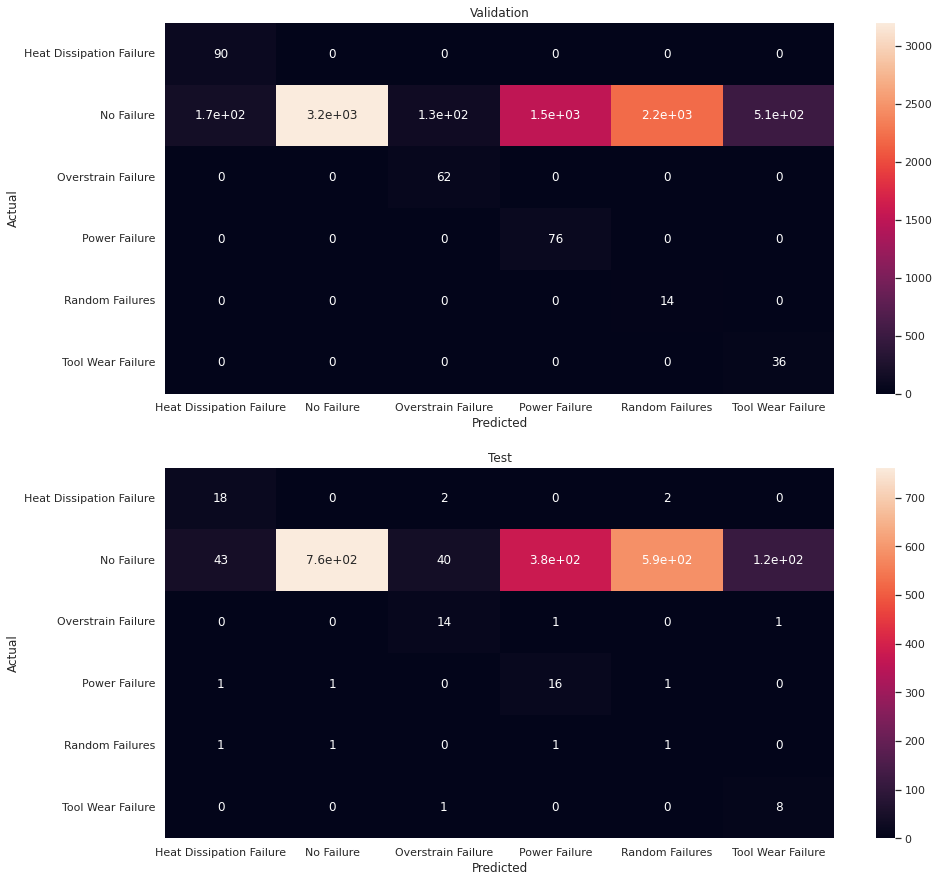

In [47]:
df_val = pd.DataFrame(cm_val, index = [y_class],
                  columns = y_class)

df_test = pd.DataFrame(cm_test, index = [y_class],
                  columns = y_class)

plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
pl = sns.heatmap(df_val, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
pl.set_title("Validation")

plt.subplot(2,1,2)
pl2 = sns.heatmap(df_test, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
pl2.set_title("Test")
plt.show()

In [48]:
print("Validation Score:")
print(classification_report(y_train,y_train_predict))
print("")
print("Test Score:")
print(classification_report(y_test,y_test_predict))

Validation Score:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        90
           1       1.00      0.41      0.59      7722
           2       0.32      1.00      0.48        62
           3       0.05      1.00      0.09        76
           4       0.01      1.00      0.01        14
           5       0.07      1.00      0.12        36

    accuracy                           0.43      8000
   macro avg       0.30      0.90      0.30      8000
weighted avg       0.97      0.43      0.58      8000


Test Score:
              precision    recall  f1-score   support

           0       0.29      0.82      0.42        22
           1       1.00      0.39      0.57      1930
           2       0.25      0.88      0.38        16
           3       0.04      0.84      0.08        19
           4       0.00      0.25      0.00         4
           5       0.06      0.89      0.12         9

    accuracy                           0.41   

Now this model is better at finding actual "Random Failure" and "Tool Wear Failure" but at the cost of more false alarm.

<a id="xgboost"></a>
## XGBoost

In [49]:
# parameters for grid search
XGB_params = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [2,5,6]
}
# Add classifier's name for grid search
pipe_XGB_params = {'xgbclassifier__' + key: XGB_params[key] for key in XGB_params}
pipe_XGB_params

{'xgbclassifier__max_depth': [3, 5, 7],
 'xgbclassifier__min_child_weight': [2, 5, 6]}

In [50]:
from xgboost import XGBClassifier

XGB_pipeline = make_pipeline( RandomUnderSampler(sampling_strategy='majority'),SMOTE(random_state=42),
                              XGBClassifier(use_label_encoder=False))

# use recall_weighted instead of recall because this is multiclass
grid_XGB = GridSearchCV(XGB_pipeline, param_grid=pipe_XGB_params, cv=skf,scoring='recall_weighted',
                        return_train_score=True)
grid_XGB.fit(X_train, y_train)
grid_XGB.best_score_

[09:20:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:20:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:20:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:20:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

0.42024999999999996

In [51]:
grid_XGB.best_params_

{'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 6}

In [52]:
y_train_predict = grid_XGB.predict(X_train)
cm_val = confusion_matrix(y_train,y_train_predict)

y_test_predict = grid_XGB.predict(X_test)
cm_test = confusion_matrix(y_test,y_test_predict)

print("Validation Score:")
print(cm_val)
print("Test Score:")
print(cm_test)

Validation Score:
[[  90    0    0    0    0    0]
 [ 148 2918  123 1741 2267  525]
 [   1    0   60    0    0    1]
 [   3    0    2   69    1    1]
 [   0    0    0    0   13    1]
 [   0    0    2    0    0   34]]
Test Score:
[[ 19   0   1   0   2   0]
 [ 36 722  36 429 589 118]
 [  1   0  14   0   0   1]
 [  1   1   0  15   2   0]
 [  0   2   0   1   1   0]
 [  0   0   1   0   0   8]]


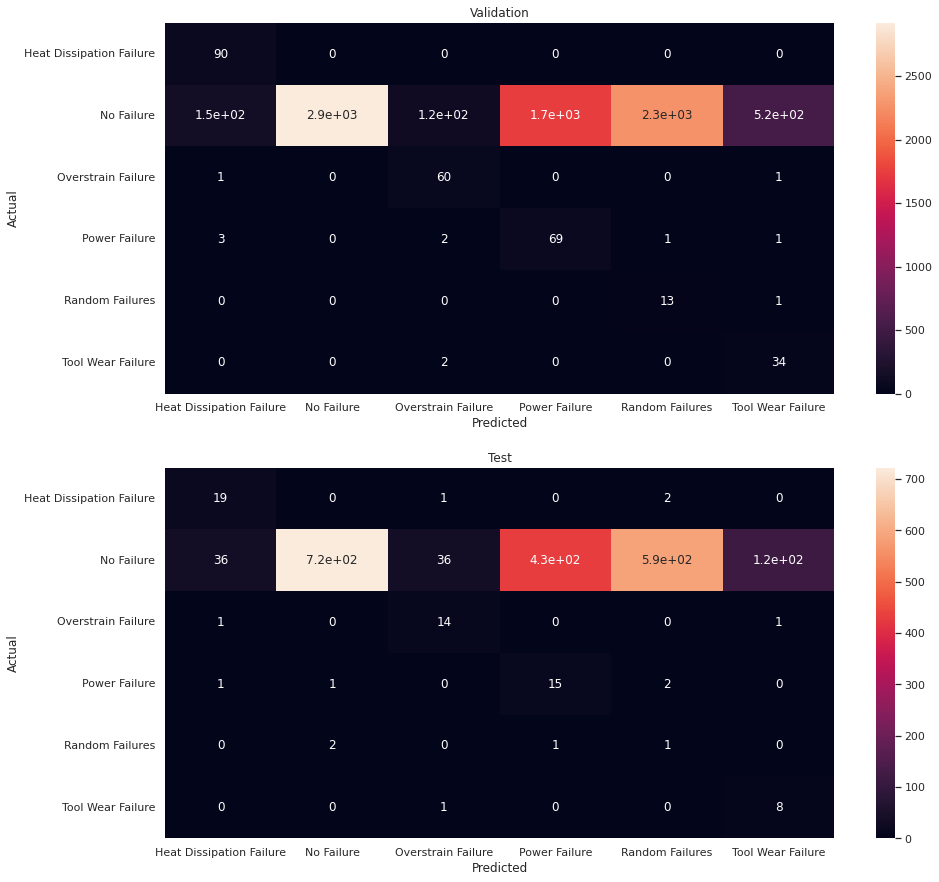

In [53]:
df_val = pd.DataFrame(cm_val, index = [y_class],
                  columns = y_class)

df_test = pd.DataFrame(cm_test, index = [y_class],
                  columns = y_class)

plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
pl = sns.heatmap(df_val, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
pl.set_title("Validation")

plt.subplot(2,1,2)
pl2 = sns.heatmap(df_test, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
pl2.set_title("Test")
plt.show()

In [54]:
print("Validation Score:")
print(classification_report(y_train,y_train_predict))
print("")
print("Test Score:")
print(classification_report(y_test,y_test_predict))

Validation Score:
              precision    recall  f1-score   support

           0       0.37      1.00      0.54        90
           1       1.00      0.38      0.55      7722
           2       0.32      0.97      0.48        62
           3       0.04      0.91      0.07        76
           4       0.01      0.93      0.01        14
           5       0.06      0.94      0.11        36

    accuracy                           0.40      8000
   macro avg       0.30      0.85      0.30      8000
weighted avg       0.97      0.40      0.54      8000


Test Score:
              precision    recall  f1-score   support

           0       0.33      0.86      0.48        22
           1       1.00      0.37      0.54      1930
           2       0.27      0.88      0.41        16
           3       0.03      0.79      0.06        19
           4       0.00      0.25      0.00         4
           5       0.06      0.89      0.12         9

    accuracy                           0.39   

There is no significant improvement comparing XGBoost with GBT.

<a id="conclusion"></a>
# Conclusion

1. We can use Over & Down Sampling to help our model see more instances in minority classes.
2. Split training & testing set before oversampling
3. Use make_pipeline to prevent polluting validation set
4. Boosting can help improve our prediction for minority classes at the cost of lower precision and misclassified majority class

Please comment if you have suggestions on how to improve this notebook. 😁

<a id="end"></a>
# [Back to top](#table-of-content)